In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.Profile import Profile
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach



onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read balance file

In [2]:
balance_paths = dict(
    SPR45 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-09 - STEP simulation for wide radiation front",
    V10 = r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-09-12 - Ryoko V10\step0_A5e21spr",
    # DTT = r"C:\Users\mikek\OneDrive\Project\DLS\from_matteo\2024-09-13 - DTT cases\20230906.Ne_1e20.SOLEDGE2D.Pump_0.9875")
)


In [3]:
eqb = dict()


for case in balance_paths:
    
    eqb[case] = dict()
    
    for side in ["ol", "il"]:
        eqb[case][side] = unpackConfigurationMK(File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=1, resolution = 2000, diagnostic_plot = False)
    
        
# file_write(eqb, "equilibrium.pkl")

# Profile grid

(-11.0, -5.659870799853643)

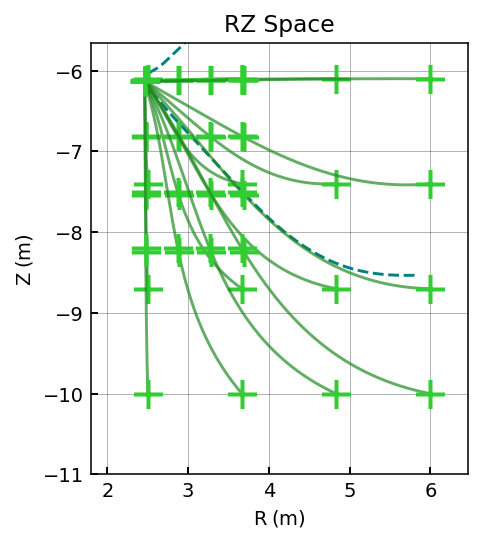

In [10]:

from fusiondls.Profile import cord_spline

p = eqb["SPR45"]["ol"]
# p.plot_topology()

self = p.copy()

bounding_profiles = {}


R_strike = 4
Z_strike = -10

def get_offsets_strike_point(pos, R_strike, Z_strike):
    
    Z_Xpoint = self["Z"][self["Xpoint"]]
    R_Xpoint = self["R"][self["Xpoint"]]

    R_strike_original = self["R"][0]
    Z_strike_original = self["Z"][0]

    cp = pd.DataFrame() # control points
    # cp["pos"] = [1, 0.5, 0.25, 0]
    cp["pos"] = pos

    spl = cord_spline(self.R_leg, self.Z_leg, return_spline=True)

    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        R, Z = spl(pos)
        cp.loc[i, "R"] = R
        cp.loc[i, "Z"] = Z

    strikeOffsetR = R_strike - R_strike_original
    strikeOffsetZ = Z_strike - Z_strike_original

    # cp["Rdist"] = -1* (cp["R"] - R_strike_original) / (cp["R"].iloc[0] - R_strike_original)
    cp["Rdist"] = (R_Xpoint - cp["R"]) / (R_Xpoint - cp["R"].iloc[-1])
    cp["Zdist"] = (Z_Xpoint - cp["Z"]) / (Z_Xpoint - cp["Z"].iloc[-1])
    cp["Rnew"] = cp["R"] + strikeOffsetR * cp["Rdist"]
    cp["Znew"] = cp["Z"] + strikeOffsetZ * cp["Zdist"]
    
    
    offsets = []
    for i, pos in enumerate(cp["pos"]):
        # controlPoints.loc[pos, "R"] = spl(pos)
        offsets.append(dict(
            pos = cp.loc[i, "pos"], 
            xpos = cp.loc[i, "Rnew"], 
            ypos = cp.loc[i, "Znew"]))
    return offsets
        
res = 4
xpoints = np.linspace(2.5, 6, res)
ypoints = np.linspace(-6.1, -10, res)

profiles = {}

for x in xpoints:
    profiles[x] = {}
    for y in ypoints:
        
        p2 = p.copy()
        offsets = get_offsets_strike_point([1, 0.6, 0.59, 0], x, y)
        p2.offset_control_points(offsets)
        profiles[x][y] = p2

fig, ax = plt.subplots()
ax.plot(p["R"], p["Z"], ls = "--")

for x in xpoints:
    for y in ypoints:
        profiles[x][y].plot_control_points(ax = ax)
# bounding_profiles["left"].plot_control_points(ax = ax)

ax.set_ylim(-11,None)
# plt.plot(p2["R_original"], p2["Z_original"])

# Run DLS

In [11]:
# results = dict()

#set switches
radios_default = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True, # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point. 
    "fluxlim": False,  # WIP - do not use. if true, turns on a flux limiter with coefficient alpha
}

#set general run parameters
constants_default = {
    "gamma_sheath": 7, #sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 0.5, # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    
    "nu0" : 0.7e20, # Upstream density (if constant)
    "cz0" : 0.02, # Impurity fraction (if constant)
    
    "Lfunc": LfuncKallenbach("Ar"), # impurity cooling function. More are available in AnalyticCoolingCurves.py
    "alpha": 1000, # WIP - do not use. flux limiting alpha. Only matters if fluxlim is true
}


constants = constants_default.copy() # Set settings to default
radios = radios_default.copy() # Set settings to default
constants["qpllu0"] = 3.25e9  

In [12]:
cvar = "power"
design = "SPR45"
side = "ol"
study = "farther_strike"

s = {}

for x in xpoints:
    s[x] = {}
    for y in ypoints:

        print(f"{x:.1f},{y:.1f}")
        d = profiles[x][y]
        # SpolRange = np.linspace(0, d["Spol"][d["Xpoint"]], 25) # 
        # SparRange = [d["S"][np.argmin(np.abs(d["Spol"] - SpolRange[x]))] for x, _ in enumerate(SpolRange)]
        SparRange = [0]

        try: 
            results = run_dls(
                constants, radios, d, 
                SparRange, 
                verbosity = 0, 
                control_variable = "density", 
                Ctol = 1e-3, 
                Ttol=1e-3,
                dynamicGrid = True,
                zero_qpllt = False)
        
        except KeyboardInterrupt:
            print("Stopped")
            sys.exit(0)
        
        s[x][y] = copy.deepcopy(results)

2.5,-6.1
Solving...0.0000...Complete in 0.6 seconds
2.5,-7.4
Solving...0.0000...Complete in 0.3 seconds
2.5,-8.7
Solving...0.0000...Complete in 0.9 seconds
2.5,-10.0
Solving...0.0000...Complete in 0.8 seconds
3.7,-6.1
Solving...0.0000...Complete in 0.8 seconds
3.7,-7.4
Solving...0.0000...Complete in 0.8 seconds
3.7,-8.7
Solving...0.0000...Complete in 0.7 seconds
3.7,-10.0
Solving...0.0000...Complete in 0.8 seconds
4.8,-6.1
Solving...0.0000...Complete in 0.8 seconds
4.8,-7.4
Solving...0.0000...Complete in 0.7 seconds
4.8,-8.7
Solving...0.0000...Complete in 3.1 seconds
4.8,-10.0
Solving...0.0000...Complete in 0.7 seconds
6.0,-6.1
Solving...0.0000...Complete in 0.7 seconds
6.0,-7.4
Solving...0.0000...Complete in 0.7 seconds
6.0,-8.7
Solving...0.0000...Complete in 0.8 seconds
6.0,-10.0
Solving...0.0000...Complete in 0.5 seconds


In [14]:
thresholds = np.zeros((len(xpoints), len(ypoints)))

for i, x in enumerate(xpoints):
    for j, y in enumerate(ypoints):
        thresholds[i,j] = s[x][y]["cvar"][0]

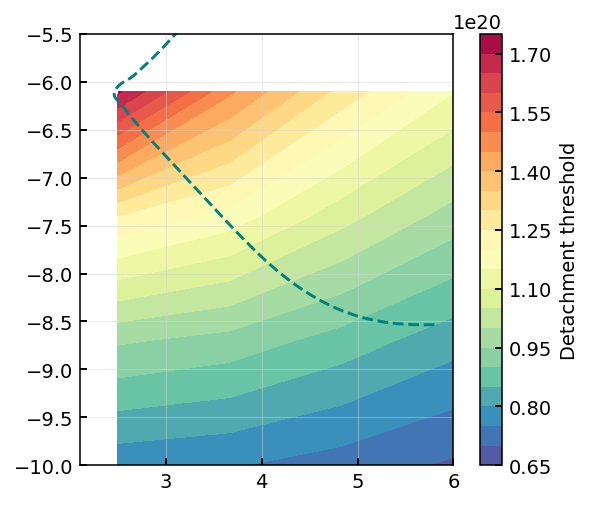

In [20]:
fig, ax = plt.subplots()
ax.plot(p["R"], p["Z"], ls = "--")

# for x in xpoints:
#     for y in ypoints:
#         profiles[x][y].plot_control_points(
#             ax = ax,
#             markersettings = {"s":0},
#             linesettings = {"linewidth":0.5, "c":"k", "alpha":0.1})
        
cf = ax.contourf(xpoints, ypoints, thresholds, levels = 20, cmap = "Spectral_r")
fig.colorbar(cf, ax = ax, label = "Detachment threshold")
ax.set_ylim(-10, -5.5)
ax.set_aspect("equal")